## Build and run a generative based chat bot

In [1]:
import numpy as np
import time
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Mount Google Drive
drive.mount('/content/drive')

# Load json data
def load_json_data(data_path):
    """
    Load JSON data from the specified path.

    Args:
        data_path (str): Path to the JSON data file.

    Returns:
        list: Loaded JSON data.
    """
    with open(data_path, 'r') as f:
        data = json.load(f)
    return data

data_path = '/content/drive/MyDrive/Genertest [MConverter.eu] (1).json'
data = load_json_data(data_path)

# Preprocessing
def preprocess_data(data):
    """
    Preprocess the JSON data to extract questions, responses, and tags.

    Args:
        data (list): JSON data containing dialogues, questions, responses, and tags.

    Returns:
        list, list, list: Lists of questions, responses, and tags.
    """
    questions = []
    responses = []
    tags = []

    for item in data:
        dialogue = item['dialogue'][0]
        questions.append(dialogue['questions'])
        responses.append(dialogue['responses'])
        tags.append(item['tags'])

    return questions, responses, tags

questions, responses, tags = preprocess_data(data)

# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>', filters='')
tokenizer.fit_on_texts(questions + responses)
vocab_size = len(tokenizer.word_index) + 1

# Convert text sequences to token sequences
def text_to_token_sequences(tokenizer, texts):
    """
    Convert a list of text sequences to token sequences using a tokenizer.

    Args:
        tokenizer (tf.keras.preprocessing.text.Tokenizer): Tokenizer to use for conversion.
        texts (list): List of text sequences.

    Returns:
        numpy.ndarray: Array of token sequences.
    """
    return tokenizer.texts_to_sequences(texts)

question_seqs = text_to_token_sequences(tokenizer, questions)
response_seqs = text_to_token_sequences(tokenizer, responses)

# Padding
max_input_length = max(len(seq) for seq in question_seqs)
question_seqs_padded = pad_sequences(question_seqs, maxlen=max_input_length)
response_seqs_padded = pad_sequences(response_seqs, padding='post')

# Update vocabulary with special tokens
tokenizer.word_index['<start>'] = vocab_size
tokenizer.word_index['<end>'] = vocab_size + 1
vocab_size += 2

# Update response sequences with special tokens
response_seqs_padded = np.hstack((np.full((len(response_seqs), 1), vocab_size - 2), response_seqs_padded))
response_seqs_padded = np.hstack((response_seqs_padded, np.full((len(response_seqs), 1), vocab_size - 1)))

# Define Encoder-Decoder Model
latent_dim = 256  # Dimensionality of the encoder and decoder hidden states

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(vocab_size, latent_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(vocab_size, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Split the data into training and validation sets
question_train, question_val, response_train, response_val = train_test_split(
    question_seqs_padded, response_seqs_padded, test_size=0.1, random_state=85
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def lr_schedule(epoch):
    if epoch < 50:
        return 0.001
    elif epoch < 75:
        return 0.0005
    else:
        return 0.0001

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    [question_train, response_train[:, :-1]],
    response_train[:, 1:],
    validation_data=([question_val, response_val[:, :-1]], response_val[:, 1:]),
    epochs=100,
    batch_size=64,
    callbacks=[lr_scheduler]
)


ModuleNotFoundError: No module named 'tensorflow'

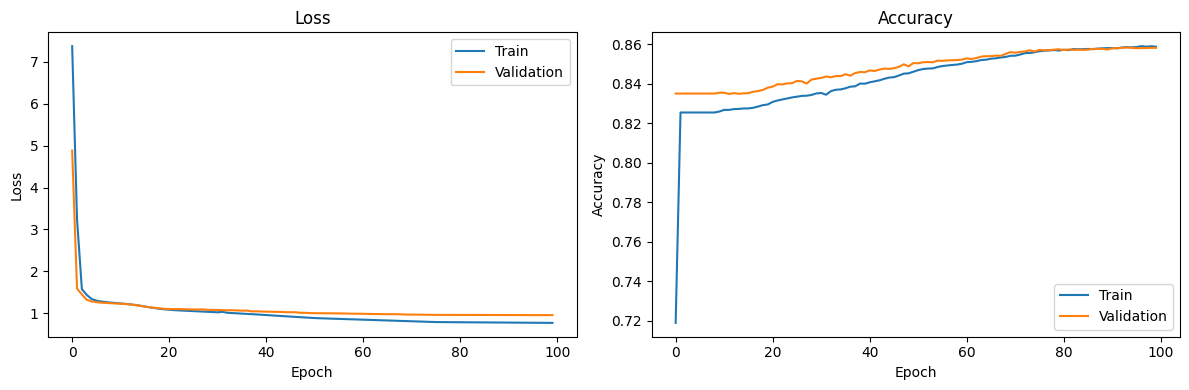

In [ ]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 4))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


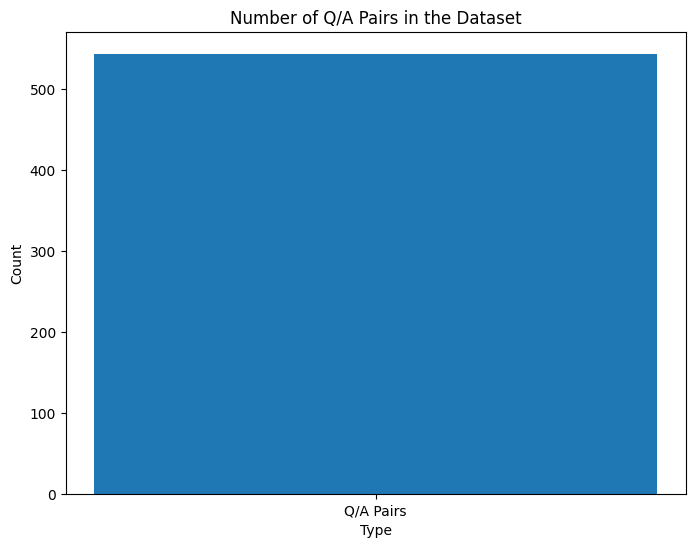

In [ ]:
# Calculate the number of Q/A pairs
num_pairs = len(questions)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Q/A Pairs'], [num_pairs])
plt.title('Number of Q/A Pairs in the Dataset')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# Inference
encoder_model = Model(encoder_inputs, encoder_states)

# Create Decoder Model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def generate_response(encoder_model, decoder_model, tokenizer, input_text, p=0.5, max_length=20):
    """
    Generate a response using nucleus sampling.

    Args:
        encoder_model (tf.keras.models.Model): Encoder model.
        decoder_model (tf.keras.models.Model): Decoder model.
        tokenizer (tf.keras.preprocessing.text.Tokenizer): Tokenizer for text conversion.
        input_text (str): Input text for generating a response.
        p (float): Nucleus sampling parameter.
        max_length (int): Maximum length of the response.

    Returns:
        str: Generated response.
    """
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_length)

    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    stop_condition = False
    response = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Apply nucleus sampling
        sorted_probs = np.sort(output_tokens[0, -1, :])
        sorted_indices = np.argsort(output_tokens[0, -1, :])
        sorted_probs = sorted_probs[::-1]  # Sort in descending order
        cumulative_probs = np.cumsum(sorted_probs)
        sorted_indices = sorted_indices[cumulative_probs <= p]

        if len(sorted_indices) == 0:
            # If no valid tokens left, break the loop
            break

        sampled_token_index = np.random.choice(sorted_indices)

        sampled_word = tokenizer.index_word.get(sampled_token_index, '')
        response += ' ' + sampled_word

        if sampled_word == '<end>' or len(response.split()) > max_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return response.strip()


In [ ]:
# Chatbot interaction loop
response_times = []
true_responses = []

while True:
    user_input = input("User: ")
    if user_input.lower() == 'exit':
        break

    start_time = time.time()

    response = generate_response(encoder_model, decoder_model, tokenizer, user_input, p=0.6, max_length=20)

    end_time = time.time()
    response_time = end_time - start_time

    print("Chatbot:", response)

    true_response = input("Enter the true response: ")
    true_responses.append(true_response)
    response_times.append(response_time)


User: hi
1/1 [==============================] - 0s 33ms/step
Chatbot: sexuality, cognitive strategies hub. equations exhaustive visa personal course. competition, self-harm statement.
Enter the true response: Hello! How can I assist you today?
User: Where is the University of Hertfordshire located?
1/1 [==============================] - 0s 22ms/step
Chatbot: bereavement, child. industries. reasonable algorithms crisis world few personal conditions sexual
Enter the true response: The University of Hertfordshire is situated in Hatfield, Hertfordshire, England. There are two primary campuses, College Lane and de Havilland, with College Lane housing the majority of the academic departments.
User: How many students are there per faculty member?
1/1 [==============================] - 0s 19ms/step
Chatbot: behavioural titles red hypnotherapy, advise 284870. cognitive life
Enter the true response: Our student-to-faculty ratio is 18:1.
User: What transportation options are available for student

In [ ]:
# Calculate response accuracy
predicted_responses = [generate_response(encoder_model, decoder_model, tokenizer, user_input, p=0.9, max_length=20)
                       for user_input in true_responses]
accuracy = accuracy_score(true_responses, predicted_responses)


1/1 [==============================] - 0s 21ms/step


In [ ]:
# Plot response times
plt.figure()
plt.plot(response_times)
plt.xlabel("User Interaction")
plt.ylabel("Response Time (seconds)")
plt.title("Generative Chatbot Response Times")
plt.show()


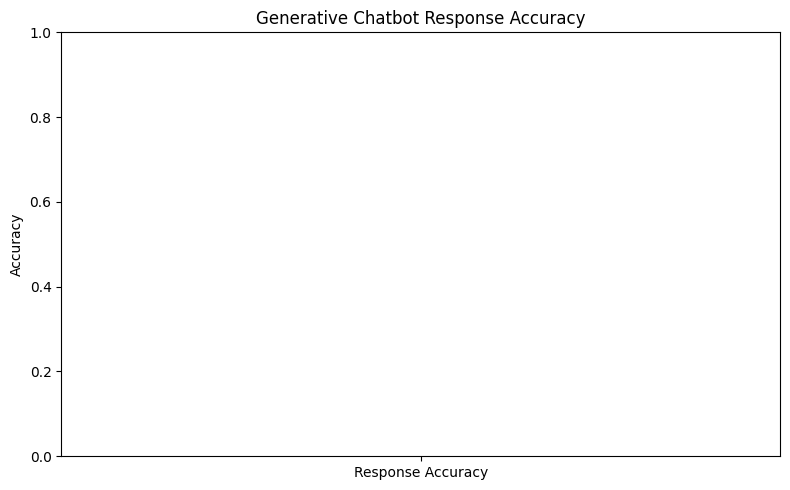

In [ ]:
# Plot response accuracy
plt.figure(figsize=(8, 5))
plt.bar(['Response Accuracy'], [accuracy])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Generative Chatbot Response Accuracy')
plt.tight_layout()
plt.show()